# MLB Story: Payroll vs Performance (2015–2024)

Last Updated: September. 1th, 2025. -Clean up needed and unneccesary figures.
This notebook presents a **clean, reproducible analysis** exploring the relationship between **MLB team payrolls** and **on‑field performance** (wins, win percentage, and championships). This notebook will be continued to evolve and be improved to create better visuals and insights.
*Note: As of Sept 1. The Current state of the note is a working progress and needs more cleaning up. Apologies for the mess!

**Sections**
1. Imports & Setup  
2. Data Loading  
3. Data Cleaning & Feature Engineering  
4. Exploratory Analysis & Visualization  

## 1) Imports & Setup

In [1]:
#Install Packages
%pip install pandas numpy matplotlib seaborn plotly scikit-learn ipython openpyxl

Note: you may need to restart the kernel to use updated packages.


In [36]:
#Import packages
# Consolidated imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import plotly.express as px #Interactive Visuals on Notebook
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency, fisher_exact, binomtest
import re
from IPython.display import display
import random

## 2) Data Loading

In [4]:
# Lahman Teams table (official mirror)
#LAHMAN_TEAMS_URL = "https://sabr.app.box.com/s/rsry2en86bimvybwsorumfsxmf91002a?page=1"
#Salary data imported from = "https://www.kaggle.com/api/v1/datasets/download/christophertreasure/mlb-player-salaries-2011-2024"

teams = pd.read_csv("Teams.csv") #Team Stat
apps = pd.read_csv("Appearances.csv") #Player Appearance
salaries = pd.read_csv("mlb_salary_data.csv", encoding="latin1")  #Player salaries, encoding latin1

# Filter 2015–2024
teams_modern = teams[(teams["yearID"] >= 2015) & (teams["yearID"] <= 2024)].copy()
apps = apps[(apps["yearID"] >= 2015) & (apps["yearID"] <= 2024)].copy()
salaries["Year"] = salaries["Year"].astype(int)
salaries = salaries[(salaries["Year"]>=2015) & (salaries["Year"]<=2024)].copy()

In [5]:
# Data check
print(teams_modern.head())
print(teams_modern.columns)

print(salaries.head())
print(salaries.columns)

print(apps.head())
print(apps.columns)

    yearID lgID teamID franchID divID  Rank    G  Ghome   W   L  ...   DP  \
55    2015   AL    LAA      ANA     W     3  162   81.0  85  77  ...  108   
56    2016   AL    LAA      ANA     W     4  162   81.0  74  88  ...  148   
57    2017   AL    LAA      ANA     W     2  162   81.0  80  82  ...  135   
58    2018   AL    LAA      ANA     W     4  162   81.0  80  82  ...  173   
59    2019   AL    LAA      ANA     W     4  162   81.0  72  90  ...  118   

       FP                           name                      park  \
55  0.984  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
56  0.983  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
57  0.986  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
58  0.987  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
59  0.984  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   

    attendance  BPF  PPF  teamIDBR  teamIDlahman45  teamIDretro  
55   3012765.0   94   95       LAA             ANA

## 3) Data Cleaning & Feature Engineering

### Lahman team table — field index

| Field             | Description |
|-------------------|-------------|
| **`yearID`**      | Year |
| `lgID`            | League |
| **`teamID`**      | Team |
| **`franchID`**    | Franchise (links to TeamsFranchise table) |
| `divID`           | Team's division |
| `Rank`            | Position in final standings |
| **`G`**           | Games played |
| `GHome`           | Games played at home |
| **`W`**           | Wins |
| **`L`**           | Losses |
| **`DivWin`**      | Division Winner (`Y`/`N`) |
| **`WCWin`**       | Wild Card Winner (`Y`/`N`) |
| **`LgWin`**       | League Champion (`Y`/`N`) |
| **`WSWin`**       | World Series Winner (`Y`/`N`) |
| **`R`**           | Runs scored |
| `AB`              | At bats |
| **`H`**           | Hits by batters |
| **`2B`**          | Doubles |
| **`3B`**          | Triples |
| **`HR`**          | Home runs by batters |
| **`BB`**          | Walks by batters |
| **`SO`**          | Strikeouts by batters |
| **`SB`**          | Stolen bases |
| `CS`              | Caught stealing |
| **`HBP`**         | Batters hit by pitch |
| **`SF`**          | Sacrifice flies |
| **`RA`**          | Opponents' runs scored |
| **`ER`**          | Earned runs allowed |
| **`ERA`**         | Earned run average |
| `CG`              | Complete games |
| `SHO`             | Shutouts (team level) |
| **`SV`**          | Saves |
| `IPOuts`          | Outs pitched (`innings * 3`) |
| `HA`              | Hits allowed |
| `HRA`             | Home runs allowed |
| `BBA`             | Walks allowed |
| `SOA`             | Strikeouts by pitchers |
| `E`               | Errors |
| `DP`              | Double plays (team level) |
| `FP`              | Fielding percentage |
| **`name`**        | Team's full name |
| `park`            | Name of team's home ballpark |
| `attendance`      | Home attendance total |
| `BPF`             | Three-year park factor (batters) |
| `PPF`             | Three-year park factor (pitchers) |
| `teamIDBR`        | Team ID used by Baseball-Reference |
| `teamIDlahman45`  | Team ID used in Lahman DB v4.5 |
| `teamIDretro`     | Team ID used by Retrosheet |

In [6]:
# Rename some ofthe Clean name and add Win Percentage
# teams like ARI, ATL, BOS etc. already match and don’t need remapping
team_map = {
    "CHN": "CHC",
    "CHA": "CHW",
    "KCA": "KC",
    "SDN": "SD",
    "SFN": "SF",
    "SLN": "STL",
    "TBA": "TB",
    "NYA": "NYY",
    "NYN": "NYM",
    "LAN": "LAD",
    "WAS": "WSH"
}

teams_modern["teamID"] = teams_modern["teamID"].replace(team_map)
apps["teamID"] = apps["teamID"].replace(team_map)

keep_cols = [
    "yearID","teamID","franchID","name",
    "W","L","G","R","RA","HR","SB","BB","SO",
    "H","2B","3B","SF","HBP","ERA","ER","SV",
    "DivWin","WCWin","LgWin","WSWin"
]
team_stats = teams_modern[keep_cols].copy()
team_stats = team_stats.rename(columns={"yearID":"Year","teamID":"Team","name":"TeamName"})
team_stats["WinPct"] = team_stats["W"] / (team_stats["W"] + team_stats["L"])

In [7]:
#Clean up the Salary dataframe
sal = salaries.copy()
sal = salaries.rename(columns={
    "Name": "Player" 
})

# Keep just the essentials; drop rows missing any
needed = ["Year","Team","Player","Salary"]
missing = [c for c in needed if c not in sal.columns]
if missing:
    raise ValueError(f"Missing needed columns: {missing}")
sal = sal[needed].dropna()

# Clean up salary string to have a INT
def to_number(x):
    if pd.isna(x): return None
    if isinstance(x,(int,float)): return x
    x = str(x)
    x = re.sub(r"[^0-9.\-]", "", x) # remove $ , and any stray text
    return pd.to_numeric(x, errors="coerce")

sal["Salary"] = sal["Salary"].apply(to_number)
sal = sal.dropna(subset=["Salary"])

In [8]:
# GINI Coefficient: measures the inequality within a group
def gini(x):
    """Gini coefficient (0=equal, 1=concentrated)."""
    arr = np.array(x, dtype=float)
    if len(arr) == 0: return np.nan
    arr = np.sort(arr)
    n = len(arr)
    cum = np.cumsum(arr)
    if arr.sum() == 0: return 0.0
    return ((n + 1) / n) - 2.0 * cum.sum() / (n * arr.sum())

# Top 'K' player's payroll share within a team
def top_share(values, k):
    vals = np.sort(np.array(values, dtype=float))[::-1]
    topk = vals[:k].sum() if len(vals)>=k else vals.sum()
    total = vals.sum()
    return topk/total if total>0 else np.nan

# Segregate Top1, 3, and 5
payroll = (
    sal.groupby(["Team","Year"])
     .agg(
         TOTAL_PAYROLL=("Salary","sum"),
         N_PLAYERS=("Player","nunique"),
         GINI=("Salary", gini),
         TOP1_SHARE=("Salary", lambda x: top_share(x,1)),
         TOP3_SHARE=("Salary", lambda x: top_share(x,3)),
         TOP5_SHARE=("Salary", lambda x: top_share(x,5)),
         MEDIAN_SAL=("Salary","median"),
         MEAN_SAL=("Salary","mean")
     )
     .reset_index()
)

# Identify the top earner per Team-Year and what their payroll is that year
top1 = (
    sal.loc[sal.groupby(["Team", "Year"])["Salary"].idxmax(), ["Team", "Year", "Player", "Salary"]]
       .rename(columns={"Player": "TOP1_PLAYER", "Salary": "TOP1_SALARY"})
       .reset_index(drop=True)
)

# Attach to the payroll summary
payroll = payroll.merge(top1, on=["Team", "Year"], how="left")

In [9]:
# Merge Payroll with Team Stat 
mlb_merged = payroll.merge(team_stats, on=["Team","Year"], how="left")

# Simplify roles and designate a role to each player
def collapse_role(row):
    roles = {
        "P": row["G_p"], #Pitcher
        "C": row["G_c"], #Catcher
        "IF": row["G_1b"] + row["G_2b"] + row["G_3b"] + row["G_ss"], #Infielder
        "OF": row["G_lf"] + row["G_cf"] + row["G_rf"], #Outfielder
        "DH": row["G_dh"] #Designated Hitter
    }
    return max(roles, key=roles.get) if sum(roles.values())>0 else "UNK"

# Apply role simplification and designation 
apps["PrimaryRole"] = apps.apply(collapse_role, axis=1)

apps_simple = apps[["yearID","teamID","playerID","PrimaryRole"]].copy()
apps_simple.rename(columns={"yearID":"Year","teamID":"Team"}, inplace=True)

In [11]:
# Quick Sanity Check
role_counts = (
    apps_simple
    .groupby(["Year","Team","PrimaryRole"])["playerID"]
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

role_counts["TOTAL_PLAYERS"] = role_counts[["P","C","IF","OF","DH"]].sum(axis=1)

# Proportions
for r in ["P","C","IF","OF","DH"]:
    role_counts[r+"_ROSTER_SHARE"] = role_counts[r] / role_counts["TOTAL_PLAYERS"]

print(role_counts.head())

cols = ["P_ROSTER_SHARE","C_ROSTER_SHARE","IF_ROSTER_SHARE","OF_ROSTER_SHARE","DH_ROSTER_SHARE"]

# calculate row-wise sum
mlb_df["share_sum"] = mlb_df[cols].sum(axis=1)

# inspect distribution
print(mlb_df["share_sum"].describe())

# check if all are equal to 1 (within floating point tolerance)
all_close = np.allclose(mlb_df["share_sum"], 1.0)
print("All rows sum to 1:", all_close)
print(mlb_df["share_sum"].head())

PrimaryRole  Year Team  C  DH  IF  OF   P  UNK  TOTAL_PLAYERS  P_ROSTER_SHARE  \
0            2015  ARI  6   0   8   9  27    0             50        0.540000   
1            2015  ATL  3   0  13   8  36    0             60        0.600000   
2            2015  BAL  3   2  10  11  22    0             48        0.458333   
3            2015  BOS  3   2  11   9  26    0             51        0.509804   
4            2015  CHC  4   0   9  10  27    0             50        0.540000   

PrimaryRole  C_ROSTER_SHARE  IF_ROSTER_SHARE  OF_ROSTER_SHARE  DH_ROSTER_SHARE  
0                  0.120000         0.160000         0.180000         0.000000  
1                  0.050000         0.216667         0.133333         0.000000  
2                  0.062500         0.208333         0.229167         0.041667  
3                  0.058824         0.215686         0.176471         0.039216  
4                  0.080000         0.180000         0.200000         0.000000  


NameError: name 'mlb_df' is not defined

In [12]:
# Merge Role count to current master dataframe (mlb_merge --> mlb_df)
mlb_df = mlb_merged.merge(role_counts, left_on=["Year","Team"], right_on=["Year","Team"], how="left")

# Approximate payroll split using roster shares
mlb_df["PitcherPayrollEst"] = mlb_df["TOTAL_PAYROLL"] * mlb_df["P_ROSTER_SHARE"] #Pitcher total payroll
mlb_df["HitterPayrollEst"]  = mlb_df["TOTAL_PAYROLL"] * (
    mlb_df["C_ROSTER_SHARE"] + mlb_df["IF_ROSTER_SHARE"] + mlb_df["OF_ROSTER_SHARE"] + mlb_df["DH_ROSTER_SHARE"]) #non-pitcher total payroll
mlb_df["PitcherPayrollShareEst"] = mlb_df["PitcherPayrollEst"] / mlb_df["TOTAL_PAYROLL"] #Pitcher payroll share
mlb_df["HitterPayrollShareEst"]  = mlb_df["HitterPayrollEst"] / mlb_df["TOTAL_PAYROLL"] #non-pitcher payroll share

# Aggregate across years (mean per team)
avg_shares = (
    mlb_df.groupby("Team")[["PitcherPayrollShareEst","HitterPayrollShareEst"]]
    .mean()
    .reset_index()
)

# Convert to long form for stacked barplot
avg_shares_long = avg_shares.melt(
    id_vars="Team",
    value_vars=["PitcherPayrollShareEst","HitterPayrollShareEst"],
    var_name="Role", value_name="Share"
)

In [13]:
# Final Clean up
# Convert Y/N → 1/0 for winner flags
flag_cols = ["DivWin", "LgWin", "WSWin"]

for c in flag_cols:
    mlb_df[c] = (
        mlb_df[c]
        .astype(str).str.strip().str.upper()          # handle ' y ', 'n', etc.
        .map({"Y": 1, "N": 0})                         # map to ints
        .fillna(0)                                     
        .astype(int)
    )

#Calculate and add Run Difference
mlb_df["RunDiff"] = mlb_df["R"] - mlb_df["RA"]

## 4) Exploratory Analysis & Visualization

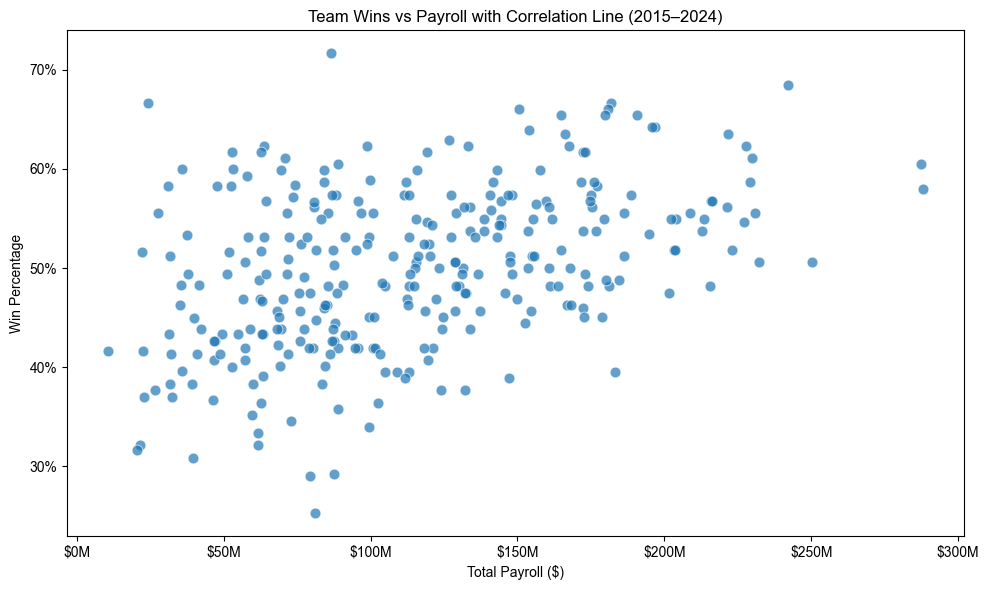

In [14]:
# drop rows with NaNs in the two columns we correlate
paired = mlb_df[["TOTAL_PAYROLL", "WinPct"]].dropna()

fig, ax = plt.subplots(figsize=(10, 6))

# scatter
sns.scatterplot(data=paired, x="TOTAL_PAYROLL", y="WinPct",
                alpha=0.7, s=60, ax=ax)

ax.set_title("Team Wins vs Payroll with Correlation Line (2015–2024)")
ax.set_xlabel("Total Payroll ($)")
ax.set_ylabel("Win Percentage")

# format axes
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: f"${x/1e9:.1f}B" if abs(x) >= 1e9 else f"${x/1e6:.0f}M"
))
ax.grid(False)
sns.set_style("ticks")

plt.tight_layout()
plt.savefig("Wins_Payroll.png", dpi=300)
plt.show()

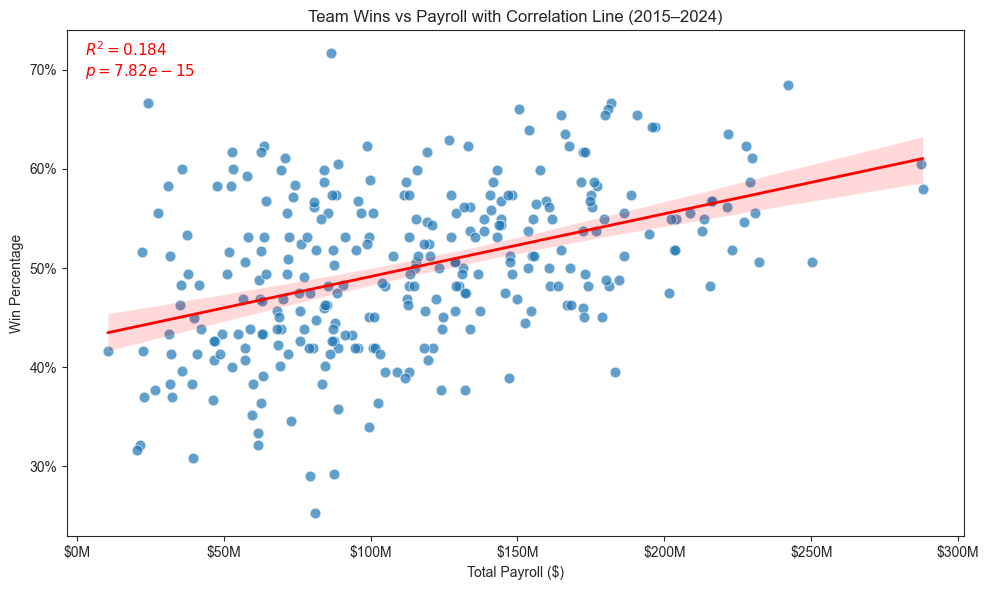

In [15]:
# drop rows with NaNs in the two columns we correlate
paired = mlb_df[["TOTAL_PAYROLL", "WinPct"]].dropna()

# Pearson r and p-value
r, p = pearsonr(paired["TOTAL_PAYROLL"], paired["WinPct"])

# compute correlation
r, pval = pearsonr(mlb_df["TOTAL_PAYROLL"], mlb_df["WinPct"])
r2 = r**2

ax.text(0.02, 0.98, f"$R^2={r**2:.3f}$  (p={p:.3g})",
        transform=ax.transAxes, ha="left", va="top", fontsize=10.5, color="red")

fig, ax = plt.subplots(figsize=(10, 6))

# scatter
sns.scatterplot(data=paired, x="TOTAL_PAYROLL", y="WinPct",
                alpha=0.7, s=60, ax=ax)

# regression line on the SAME axes
sns.regplot(data=paired, x="TOTAL_PAYROLL", y="WinPct",
            scatter=False, ci=95, line_kws={"color": "red", "lw": 2}, ax=ax)

# annotation on the SAME axes
ax.text(0.02, 0.98, f"$R^2 = {r2:.3f}$\n$p={pval:.3g}$",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=11, color="red")

ax.set_title("Team Wins vs Payroll with Correlation Line (2015–2024)")
ax.set_xlabel("Total Payroll ($)")
ax.set_ylabel("Win Percentage")

# format axes
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: f"${x/1e9:.1f}B" if abs(x) >= 1e9 else f"${x/1e6:.0f}M"
))
ax.grid(False)
sns.set_style("ticks")

plt.tight_layout()
plt.savefig("Wins_Payroll_withLine.png", dpi=300)
plt.show()

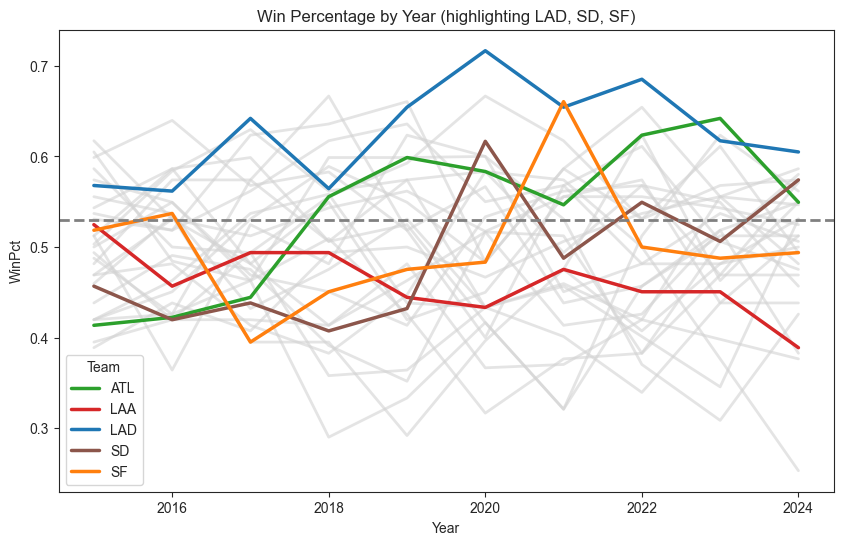

In [16]:
#California Teams' Win Percentage across the year. 

focus = {"ATL","LAA","LAD","SD","SF"}
focus_palette = {"ATL":"tab:green","LAA":"tab:red","LAD":"tab:blue","SD":"tab:brown","SF":"tab:orange"}

bg = mlb_df[~mlb_df["Team"].isin(focus)]   # non-focus
fg = mlb_df[ mlb_df["Team"].isin(focus)]   # focus

plt.figure(figsize=(10,6))

# 1) draw ALL other teams in gray, no legend
sns.lineplot(
    data=bg, x="Year", y="WinPct",
    units="Team", estimator=None,   # draw one line per team
    color="lightgray", linewidth=2, alpha=0.6,
    legend=False
)

# 2) draw focus teams in color, WITH legend
ax = sns.lineplot(
    data=fg, x="Year", y="WinPct",
    hue="Team", palette=focus_palette,
    linewidth=2.5, alpha=1.0, legend=True
)
plt.axhline(0.53, color="gray", linestyle="--", linewidth=2)

ax.grid(False)
ax.set_title("Win Percentage by Year (highlighting LAD, SD, SF)")
ax.set_ylabel("WinPct")
plt.savefig("WinPct_year.png", dpi=300)
plt.show()

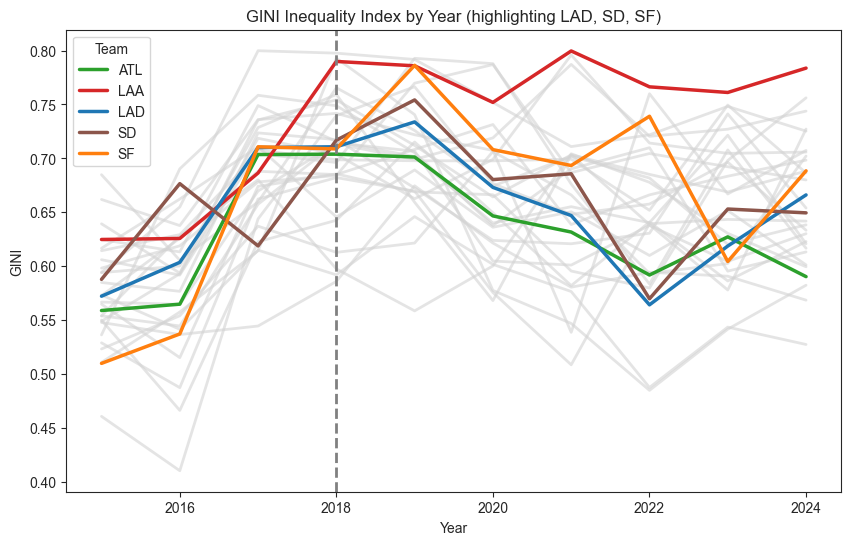

In [17]:
# California teams' GINI over the years

focus = {"ATL","LAA","LAD","SD","SF"}
focus_palette = {"ATL":"tab:green","LAA":"tab:red","LAD":"tab:blue","SD":"tab:brown","SF":"tab:orange"}

bg = mlb_df[~mlb_df["Team"].isin(focus)]   # non-focus
fg = mlb_df[ mlb_df["Team"].isin(focus)]   # focus

plt.figure(figsize=(10,6))

# 1) draw ALL other teams in gray, no legend
sns.lineplot(
    data=bg, x="Year", y="GINI",
    units="Team", estimator=None,   # draw one line per team
    color="lightgray", linewidth=2, alpha=0.6,
    legend=False
)

# 2) draw focus teams in color, WITH legend
ax = sns.lineplot(
    data=fg, x="Year", y="GINI",
    hue="Team", palette=focus_palette,
    linewidth=2.5, alpha=1.0, legend=True
)
ax.grid(False)

plt.axvline(2018, color="gray", linestyle="--", linewidth=2)

ax.set_title("GINI Inequality Index by Year (highlighting LAD, SD, SF)")
ax.set_ylabel("GINI")
plt.savefig("GINI_year.png", dpi=300)
plt.show()

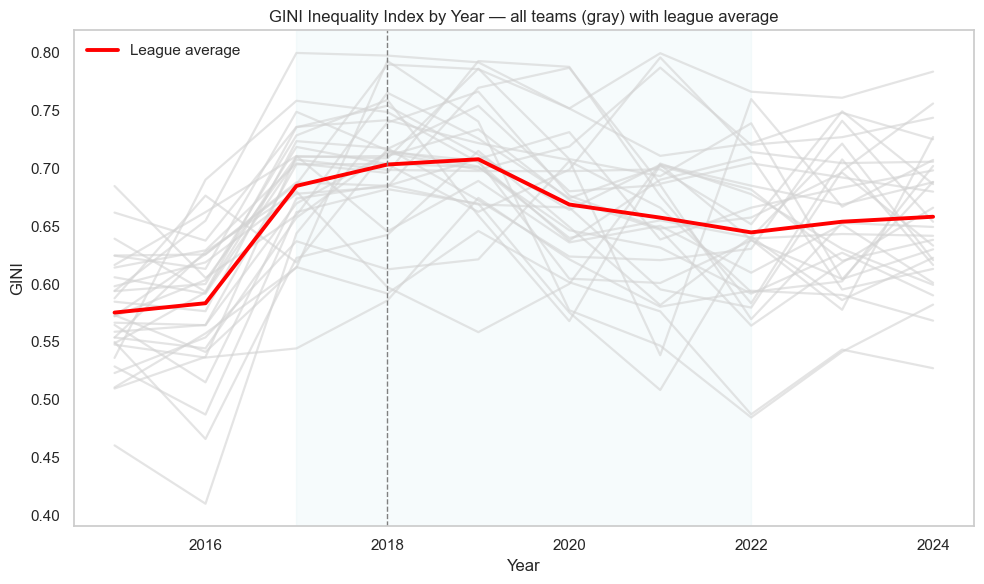

In [39]:
df = mlb_df.copy()
# ensure types
if df["Year"].dtype.kind not in "iu":
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year","Team","GINI"])

fig, ax = plt.subplots(figsize=(10,6))

# 1) all individual teams in gray (one line per team, no legend)
sns.lineplot(
    data=df, x="Year", y="GINI",
    units="Team", estimator=None,
    color="lightgray", linewidth=1.6, alpha=0.6,
    ax=ax, legend=False
)

# 2) league average by year (bold black)
gp = df.groupby("Year")["GINI"]
years = np.sort(df["Year"].unique())
avg = gp.mean().reindex(years)
se  = gp.sem().reindex(years)  # standard error for CI

ax.plot(years, avg, color="red", linewidth=2.8, ms=4, label="League average")

# (optional) 95% CI band around the average
#ax.fill_between(years, (avg - 1.96*se), (avg + 1.96*se),
#                color="black", alpha=0.10, linewidth=0)

ax.axvspan(2017, 2022, color="lightblue", alpha=0.10)
#ax.axhline(0.620, color="black", ls="--", lw=1.5)
ax.axvline(2018, color='gray', ls="--", lw=1)

# labels & look
ax.set_title("GINI Inequality Index by Year — all teams (gray) with league average", loc="center")
ax.set_xlabel("Year")
ax.set_ylabel("GINI")
ax.legend(frameon=False, loc="upper left")
ax.grid(False)
plt.tight_layout()
plt.savefig("GINI_all_teams_with_average.png", dpi=300)
plt.show()

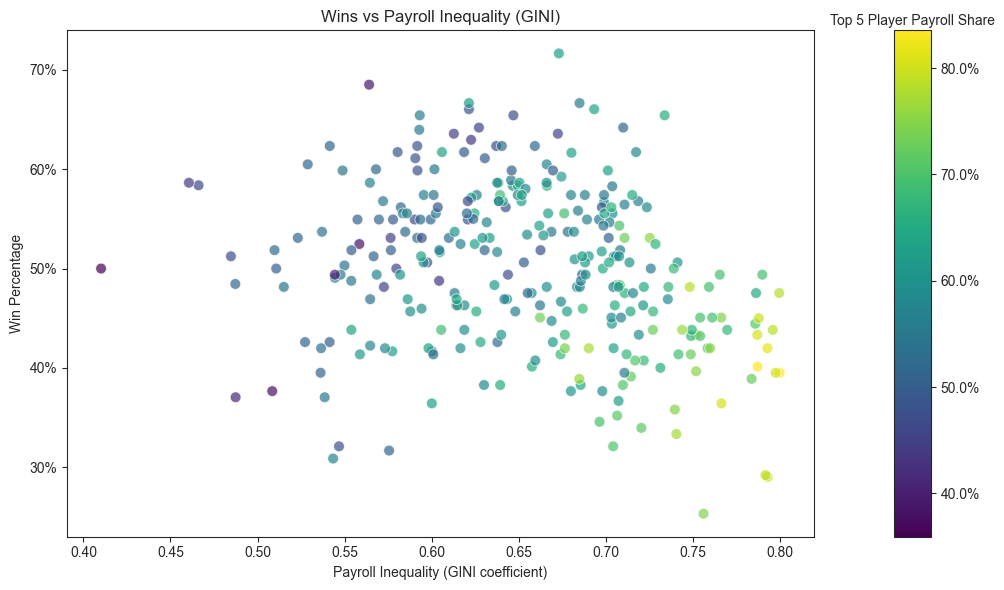

In [18]:
#Win vs Payroll Inequality with Top5 player
fig, ax = plt.subplots(figsize=(10,6))

norm = plt.Normalize(mlb_df["TOP5_SHARE"].min(), mlb_df["TOP5_SHARE"].max())

sns.scatterplot(
    data=mlb_df, x="GINI", y="WinPct",
    hue="TOP5_SHARE", palette="viridis", hue_norm=norm,
    alpha=0.7, s=60, legend=False, ax=ax
)

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.8)  # outside the plot
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.set_title("Top 5 Player Payroll Share", size=10, pad=4)
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title("Wins vs Payroll Inequality (GINI)")
ax.set_xlabel("Payroll Inequality (GINI coefficient)")
ax.set_ylabel("Win Percentage")
plt.tight_layout()
plt.savefig("Wins_Inequality_Top5.png", dpi=300)
plt.show()

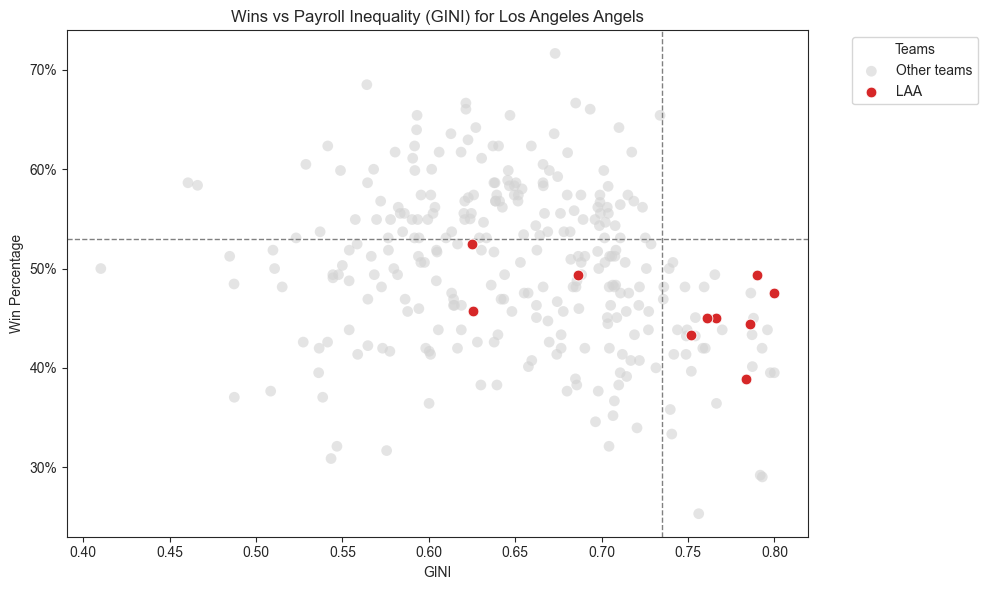

In [19]:
#Payroll inequality (GINI) v Win Percentage
# color by LAA

others = mlb_df[mlb_df["Team"] != "LAA"]
laa    = mlb_df[mlb_df["Team"] == "LAA"]

fig,ax = plt.subplots(figsize=(10,6))
# 1) everyone else (underlay)
sns.scatterplot(
    data=others, x="GINI", y="WinPct",
    color="lightgray", s=60, alpha=0.6, edgecolor="none",
    ax=ax, zorder=1, label="Other teams"
)

# 2) LAA on top (overlay)
sns.scatterplot(
    data=laa, x="GINI", y="WinPct",
    color="tab:red", s=60,
    #marker="X",
    #edgecolor="black", linewidth=0.6,
    ax=ax, zorder=3, label="LAA"
)

plt.title("Wins vs Payroll Inequality (GINI) for Los Angeles Angels")
plt.xlabel("GINI")
plt.ylabel("Win Percentage")
plt.legend(title="Teams", bbox_to_anchor=(1.05,1), loc="upper left")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.axhline(0.53, color="gray", linestyle="--", linewidth=1)
plt.axvline(0.735, color="gray", linestyle="--", linewidth=1)
ax.grid(False)

plt.tight_layout()
plt.savefig("Wins_GINI_LAA.png", dpi=300)
plt.show()

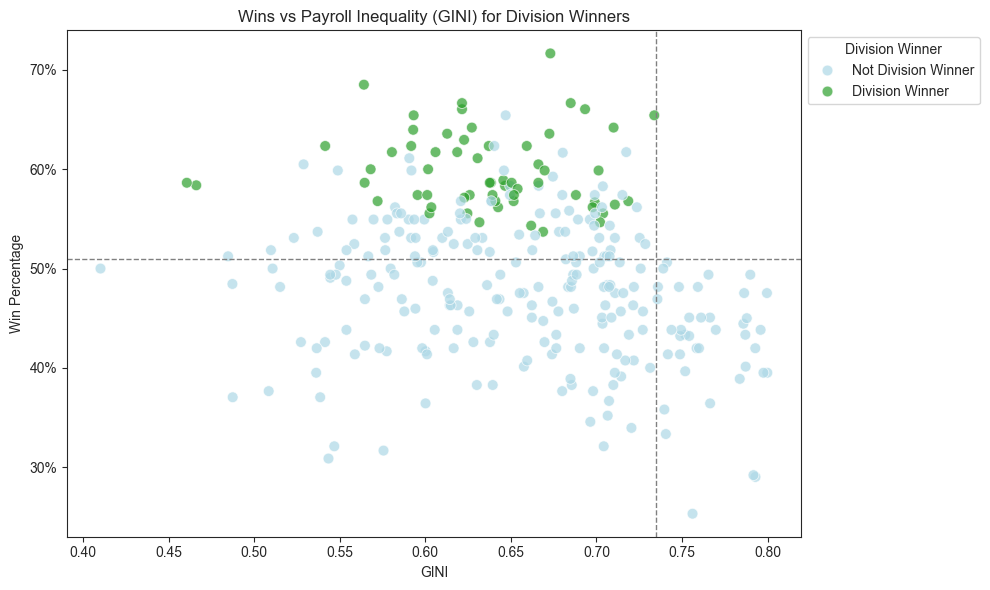

In [20]:
#Payroll inequality (GINI) v Win Percentage
# color by Division winner
df = mlb_df.copy()

# Map 0/1 → text labels (and fix legend order)
df["DivWinLabel"] = np.where(df["DivWin"].eq(1), "Division Winner", "Not Division Winner")
df["DivWinLabel"] = pd.Categorical(
    df["DivWinLabel"],
    categories=["Not Division Winner", "Division Winner"],  # legend/order
    ordered=True
)

fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="GINI",
    y="WinPct",
    hue="DivWinLabel",
    palette={ "Division Winner": "tab:green","Not Division Winner": "lightblue"},
    alpha=0.7,
    s=60,
    ax=ax
)
plt.title("Wins vs Payroll Inequality (GINI) for Division Winners")
plt.xlabel("GINI")
plt.ylabel("Win Percentage")
plt.legend(title="Division Winner", bbox_to_anchor=(1,1), loc="upper left")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.axhline(0.51, color="gray", linestyle="--", linewidth=1)
plt.axvline(0.735, color="gray", linestyle="--", linewidth=1)
ax.grid(False)
plt.tight_layout()
plt.savefig("Wins_GINI_DivWin.png", dpi=300)
plt.show()

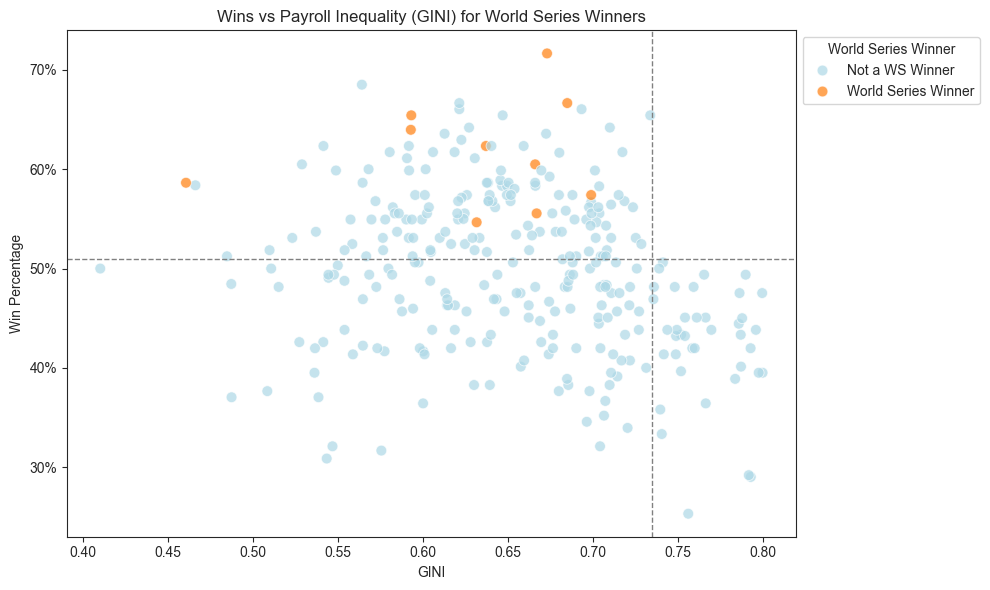

In [21]:
#Payroll inequality (GINI) v Win Percentage
# color by WS winner
# Map 0/1 → text labels (and fix legend order)
df["WSWinLabel"] = np.where(df["WSWin"].eq(1), "World Series Winner", "Not a WS Winner")
df["WSWinLabel"] = pd.Categorical(
    df["WSWinLabel"],
    categories=["Not a WS Winner", "World Series Winner"],  # legend/order
    ordered=True
)

fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="GINI",
    y="WinPct",
    hue="WSWinLabel",
    palette={ "World Series Winner": "tab:orange","Not a WS Winner": "lightblue"},
    alpha=0.7,
    s=60,
    ax=ax
)
plt.title("Wins vs Payroll Inequality (GINI) for World Series Winners")
plt.xlabel("GINI")
plt.ylabel("Win Percentage")
plt.legend(title="World Series Winner", bbox_to_anchor=(1,1), loc="upper left")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.axhline(0.51, color="gray", linestyle="--", linewidth=1)
plt.axvline(0.735, color="gray", linestyle="--", linewidth=1)
ax.grid(False)

plt.tight_layout()
plt.savefig("Wins_GINI_WSWin.png", dpi=300)
plt.show()

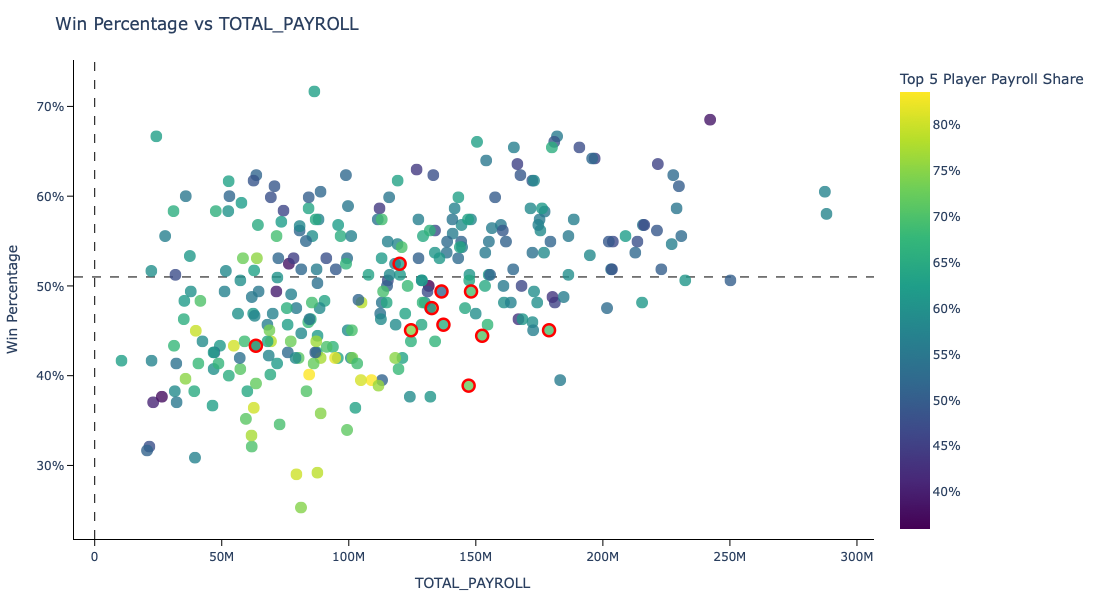

In [22]:
#Interactive scatter plot of Gini vs Win Pct for Fun
fig = px.scatter(
    mlb_df,
    x="TOTAL_PAYROLL",
    y="WinPct",
    color="TOP5_SHARE",
    hover_name="Team",
    hover_data={
        "Year": True,
        "TOTAL_PAYROLL": ":,.0f",   # 1,234,567
        "N_PLAYERS": True,
        "TOP1_SHARE": ":.3f",
        "TOP3_SHARE": ":.3f",
        "TOP5_SHARE": ".3f",        
        "TOP1_PLAYER": True,      # uncomment if these cols exist
        "TOP1_SALARY": ":,.0f",
        "Team": True               # already shown via hover_name
    },
    color_continuous_scale="Viridis",
    labels={"WinPct": "Win Percentage", "GINI": "Salary Inequality (Gini)"},
    title="Win Percentage vs TOTAL_PAYROLL"
)
# make every marker bigger (e.g., 14px)
fig.update_traces(marker=dict(size=12, opacity=0.8))

# y-axis as percent
fig.update_yaxes(tickformat=".0%")

# Colorbar title on top + percent ticks
fig.update_coloraxes(colorbar=dict(title="Top 5 Player Payroll Share", title_side="top", tickformat=".0%"))

# LAA outline overlay (drawn on top)
angels = mlb_df[mlb_df["Team"] == "LAA"]
fig.add_scatter(
    x=angels["TOTAL_PAYROLL"], y=angels["WinPct"],
    mode="markers",
    marker=dict(size=12, color="rgba(0,0,0,0)", line=dict(color="red", width=2.5)),
    name="LAA", showlegend=False
)

# transparent background (keep axes)
fig.update_layout(
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    legend=dict(bgcolor="rgba(0,0,0,0)")
)

# show axes & ticks, hide grid/zeroline
fig.update_xaxes(
    showline=True, linecolor="black", linewidth=1,
    ticks="outside", ticklen=6, tickwidth=1, tickcolor="black",
    showgrid=False, zeroline=False
)
fig.update_yaxes(
    showline=True, linecolor="black", linewidth=1,
    ticks="outside", ticklen=6, tickwidth=1, tickcolor="black",
    showgrid=False, zeroline=False
)

# Guide lines
fig.add_hline(y=0.51,  line_dash="dash", line_color="black", line_width=1, layer="below")
fig.add_vline(x=0.735, line_dash="dash", line_color="black", line_width=1, layer="below")

fig.update_layout(hovermode="closest", margin=dict(l=40, r=40, t=60, b=40), width=1000, height=600)

fig.show()

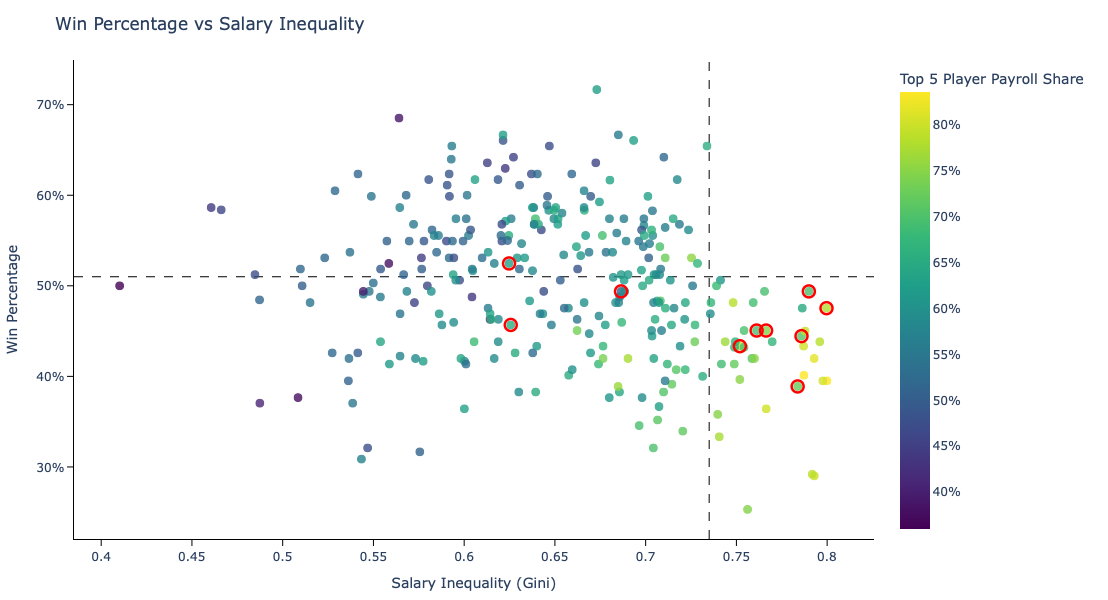

In [23]:
#Interactive scatter plot of Gini vs Win Pct
fig = px.scatter(
    mlb_df,
    x="GINI",
    y="WinPct",
    color="TOP5_SHARE",
    hover_name="Team",
    hover_data={
        "Year": True,
        "TOTAL_PAYROLL": ":,.0f",   # 1,234,567
        "N_PLAYERS": True,
        "TOP1_SHARE": ":.3f",
        "TOP3_SHARE": ":.3f",
        "TOP5_SHARE": ":.3f",        
        "TOP1_PLAYER": True,      # uncomment if these cols exist
        "TOP1_SALARY": ":,.0f",
        "Team": True               # already shown via hover_name
    },
    color_continuous_scale="Viridis",
    labels={"WinPct": "Win Percentage", "GINI": "Salary Inequality (Gini)"},
    title="Win Percentage vs Salary Inequality"
)
# make every marker bigger (e.g., 14px)
fig.update_traces(marker=dict(size=9, opacity=0.8))

# y-axis as percent
fig.update_yaxes(tickformat=".0%")

# Colorbar title on top + percent ticks
fig.update_coloraxes(colorbar=dict(title="Top 5 Player Payroll Share", title_side="top", tickformat=".0%"))

# LAA outline overlay (drawn on top)
angels = mlb_df[mlb_df["Team"] == "LAA"]
fig.add_scatter(
    x=angels["GINI"], y=angels["WinPct"],
    mode="markers",
    marker=dict(size=12, color="rgba(0,0,0,0)", line=dict(color="red", width=2.5)),
    name="LAA", showlegend=False
)

# transparent background (keep axes)
fig.update_layout(
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    legend=dict(bgcolor="rgba(0,0,0,0)")
)

# show axes & ticks, hide grid/zeroline
fig.update_xaxes(
    showline=True, linecolor="black", linewidth=1,
    ticks="outside", ticklen=6, tickwidth=1, tickcolor="black",
    showgrid=False, zeroline=False
)
fig.update_yaxes(
    showline=True, linecolor="black", linewidth=1,
    ticks="outside", ticklen=6, tickwidth=1, tickcolor="black",
    showgrid=False, zeroline=False
)

# Guide lines
fig.add_hline(y=0.51,  line_dash="dash", line_color="black", line_width=1, layer="below")
fig.add_vline(x=0.735, line_dash="dash", line_color="black", line_width=1, layer="below")

fig.update_layout(hovermode="closest", margin=dict(l=40, r=40, t=60, b=40), width=1000, height=600)

fig.show()

In [27]:
# thresholds
g_thr = 0.735
w_thr = 0.51

df = mlb_df.dropna(subset=["GINI","WinPct"]).copy()
df["hi_gini"] = df["GINI"] > g_thr
df["hi_win"]  = df["WinPct"] > w_thr

# 1) counts in each quadrant
ct = pd.crosstab(df["hi_gini"], df["hi_win"]).reindex(
    index=[False, True], columns=[False, True], fill_value=0
)
n_ll = int(ct.loc[False, False])  # low GINI, low WinPct
n_lh = int(ct.loc[False, True])   # low GINI, high WinPct
n_hl = int(ct.loc[True,  False])  # high GINI, low WinPct
n_hh = int(ct.loc[True,  True])   # high GINI, high WinPct  (the "void?" cell)

print("Quadrant counts:\n", ct)

# 2) chi-square (independence)
chi2, p_chi, dof, exp = chi2_contingency(ct)
exp_hh = exp[1,1]
print(f"\nChi-square p={p_chi:.4g}  | observed HH={n_hh}, expected HH≈{exp_hh:.1f}")

# 3) Fisher exact (one-sided: is HH under-represented?)
table = np.array([[n_ll, n_lh],
                  [n_hl, n_hh]])
oddsratio, p_fish_less = fisher_exact(table, alternative="less")
print(f"Fisher one-sided (HH underrepresented): p={p_fish_less:.4g}, odds ratio={oddsratio:.3f}")

# 4) permutation test: how often would HH be this small if WinPct were unrelated to GINI?
rng = np.random.default_rng(0)
hg = df["hi_gini"].to_numpy()
hw = df["hi_win"].to_numpy()
obs = int((hg & hw).sum())
sims = 10000
counts = np.empty(sims, dtype=int)
for i in range(sims):
    counts[i] = int((hg & rng.permutation(hw)).sum())
p_perm = (counts <= obs).mean()
print(f"Permutation p (HH <= observed): {p_perm:.4f}")

Quadrant counts:
 hi_win   False  True 
hi_gini              
False      119    141
True        39      0

Chi-square p=7.532e-10  | observed HH=0, expected HH≈18.4
Fisher one-sided (HH underrepresented): p=1.248e-12, odds ratio=0.000
Permutation p (HH <= observed): 0.0000


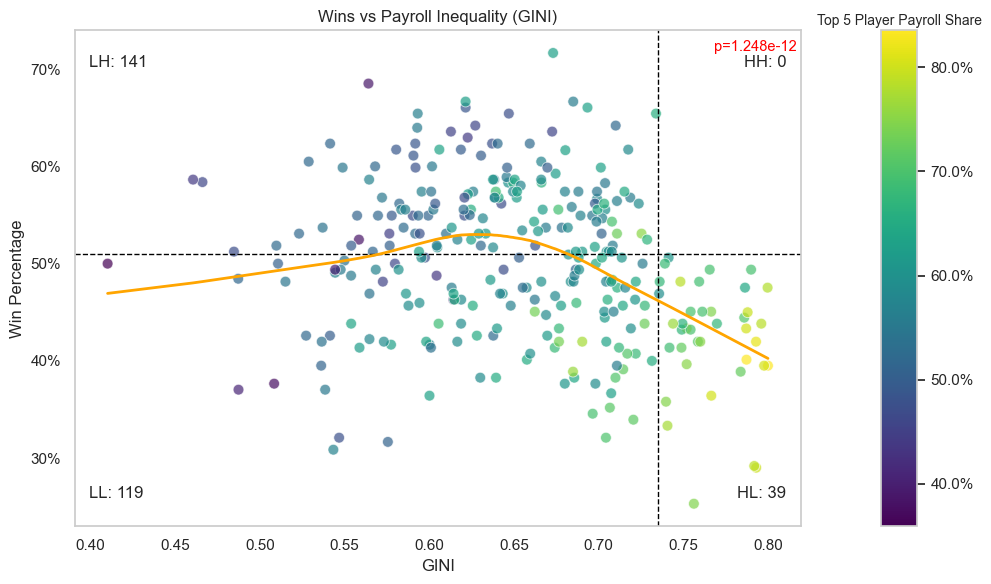

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

norm = plt.Normalize(mlb_df["TOP5_SHARE"].min(), mlb_df["TOP5_SHARE"].max())

# Scatter (colored by TOP5 share)
sns.scatterplot(
    data=mlb_df, x="GINI", y="WinPct",
    hue="TOP5_SHARE", palette="viridis", hue_norm=norm,
    alpha=0.7, s=60, legend=False, ax=ax
)

# Colorbar (outside)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.8)
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.set_title("Top 5 Player Payroll Share", size=10, pad=4)
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# smooth LOWESS curve in red
sns.regplot(
    data=mlb_df, x="GINI", y="WinPct",
    scatter=False, lowess=True, ci=None, ax=ax,
    line_kws={"color":"orange", "lw":2, "zorder":3}
)

ax.text(0.88, 0.98, f"p={p_fish_less:.4g}",
        transform=ax.transAxes, ha="left", va="top", fontsize=10.5, color="red")
# Axes formatting
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title("Wins vs Payroll Inequality (GINI)")
ax.set_xlabel("GINI")
ax.set_ylabel("Win Percentage")

g_thr, w_thr = 0.735, 0.51
ax.axvline(g_thr, color="black", ls="--", lw=1)
ax.axhline(w_thr, color="black", ls="--", lw=1)
ax.text(0.02, 0.05, f"LL: {119}", transform=ax.transAxes, ha="left", va="bottom")
ax.text(0.02, 0.95, f"LH: {141}", transform=ax.transAxes, ha="left", va="top")
ax.text(0.98, 0.05, f"HL: {39}",  transform=ax.transAxes, ha="right", va="bottom")
ax.text(0.98, 0.95, f"HH: {0}",   transform=ax.transAxes, ha="right", va="top")
ax.grid(False)
ax.set_facecolor('none')        # axes (plot area)
fig.patch.set_alpha(0)          # figure canvas

plt.tight_layout()

plt.savefig("Wins_Inequality_Top5_Perm.png", dpi=300)
plt.show()

In [29]:
df = mlb_df.dropna(subset=["GINI","WinPct"]).copy()
g_grid = np.round(np.linspace(0.70, 0.78, 17), 3)   # try ranges you care about
w_grid = np.round(np.linspace(0.50, 0.56, 13), 3)

rows=[]
for g in g_grid:
    for w in w_grid:
        hi_g = df["GINI"]>g; hi_w = df["WinPct"]>w
        ct = pd.crosstab(hi_g, hi_w)
        a = int(ct.get(False, pd.Series([0,0])).iloc[0] if False in ct.index else 0)
        b = int(ct.get(True,  pd.Series([0,0])).iloc[0] if True  in ct.columns else 0)
        c = int(ct.get(False, pd.Series([0,0])).iloc[1] if False in ct.index else 0)
        d = int(ct.get(True,  pd.Series([0,0])).iloc[1] if True  in ct.columns else 0)
        # Fisher one-sided: is HH (d) underrepresented?
        _, p = fisher_exact([[a,b],[c,d]], alternative="less")
        rows.append((g,w,d,p))
sens = pd.DataFrame(rows, columns=["GINI_thr","Win_thr","HH_count","p_less"])
# e.g., look where HH_count==0 or p_less<0.05

In [30]:
# how many grid cells show a literal void?
n_void = (sens["HH_count"] == 0).sum()
print(f"Cells with HH_count == 0: {n_void} / {len(sens)}")

# best (smallest) p-value and where it occurs
i_min = sens["p_less"].idxmin()
print("Min p:", sens.loc[i_min, "p_less"],
      "at GINI_thr=", sens.loc[i_min, "GINI_thr"],
      "Win_thr=", sens.loc[i_min, "Win_thr"])

# top 10 most significant cells
print(sens.sort_values("p_less").head(10))

# share of cells that are significant at 0.05 and 0.01
print("p<0.05:", (sens["p_less"] < 0.05).mean())
print("p<0.01:", (sens["p_less"] < 0.01).mean())

Cells with HH_count == 0: 126 / 221
Min p: 1.248146968041809e-12 at GINI_thr= 0.735 Win_thr= 0.51
     GINI_thr  Win_thr  HH_count        p_less
93      0.735    0.510         0  1.248147e-12
91      0.735    0.500         1  4.835260e-12
92      0.735    0.505         1  6.434513e-12
94      0.735    0.515         0  1.122043e-11
80      0.730    0.510         1  1.301122e-11
78      0.730    0.500         2  2.542483e-11
106     0.740    0.510         0  2.719792e-11
79      0.730    0.505         2  3.391965e-11
52      0.720    0.500         5  3.525024e-11
53      0.720    0.505         5  4.921103e-11
p<0.05: 1.0
p<0.01: 0.9864253393665159


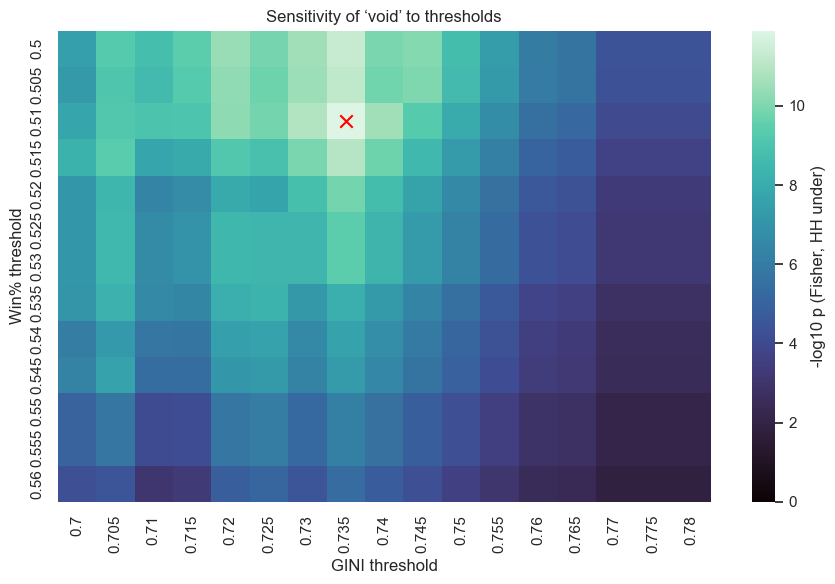

In [31]:
# pivot to a grid for plotting
grid = sens.pivot(index="Win_thr", columns="GINI_thr", values="p_less")

plt.figure(figsize=(9,6))
sns.heatmap(-np.log10(grid), cmap="mako", cbar_kws={"label": "-log10 p (Fisher, HH under)"},
            vmin=0)  # bigger = more significant
# draw a contour where p<0.05
plt.contour((grid < 0.05).astype(float), levels=[0.5], colors="white", linewidths=1)

# optionally mark your chosen thresholds
g_thr, w_thr = 0.735, 0.51
if g_thr in grid.columns and w_thr in grid.index:
    j = list(grid.columns).index(g_thr)
    i = list(grid.index).index(w_thr)
    plt.scatter(j+0.5, i+0.5, marker="x", s=80, c="red")

plt.title("Sensitivity of ‘void’ to thresholds")
plt.xlabel("GINI threshold")
plt.ylabel("Win% threshold")
plt.tight_layout()
plt.show()

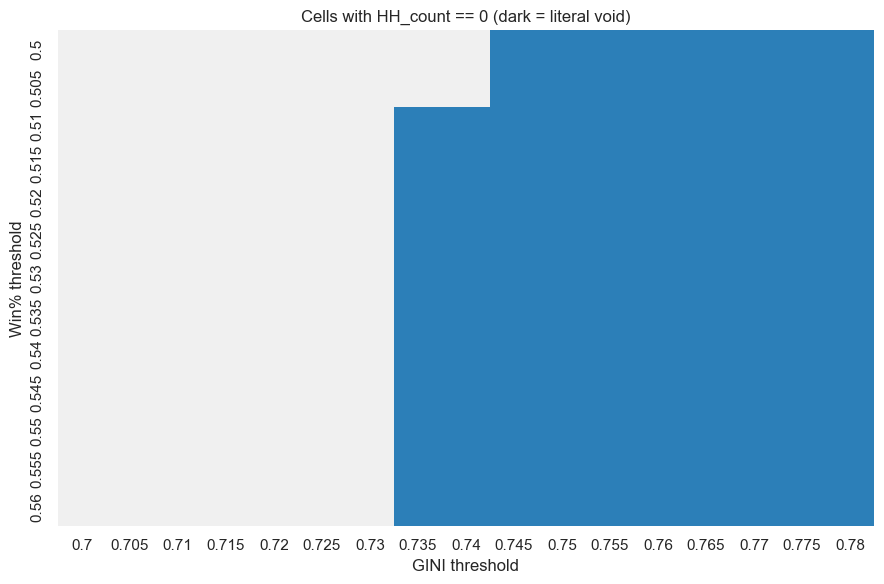

In [32]:
void_map = sens.pivot(index="Win_thr", columns="GINI_thr", values="HH_count") == 0
plt.figure(figsize=(9,6))
sns.heatmap(void_map, cmap=["#f0f0f0","#2c7fb8"], cbar=False)
plt.title("Cells with HH_count == 0 (dark = literal void)")
plt.xlabel("GINI threshold"); plt.ylabel("Win% threshold")
plt.tight_layout(); plt.show()

In [33]:
g_thr, w_thr = 0.734, 0.51

d = mlb_df.dropna(subset=["GINI","WinPct"]).copy()
d["hi_gini"] = d["GINI"] > g_thr
d["hi_win"]  = d["WinPct"] > w_thr

ct = pd.crosstab(d["hi_gini"], d["hi_win"]).reindex(
    index=[False, True], columns=[False, True], fill_value=0
)
n_ll = int(ct.loc[False, False])
n_lh = int(ct.loc[False, True])
n_hl = int(ct.loc[True,  False])
n_hh = int(ct.loc[True,  True])

# One-sided Fisher: is the high-GINI & high-win cell underrepresented?
odds, p_less = fisher_exact([[n_ll, n_lh],[n_hl, n_hh]], alternative="less")

# Exact 95% CI for P(HighWin | HighGINI)
n_high = n_hl + n_hh
x = n_hh
ci = binomtest(x, n_high).proportion_ci(confidence_level=0.95, method="exact")

print(ct)
print(f"Fisher p (HH underrepresented): {p_less:.4g}")
print(f"P(HighWin | HighGINI) = {x}/{n_high} = {x/n_high:.3f} "
      f"(95% CI {ci.low:.3f}–{ci.high:.3f})")

hi_win   False  True 
hi_gini              
False      119    141
True        39      0
Fisher p (HH underrepresented): 1.248e-12
P(HighWin | HighGINI) = 0/39 = 0.000 (95% CI 0.000–0.090)


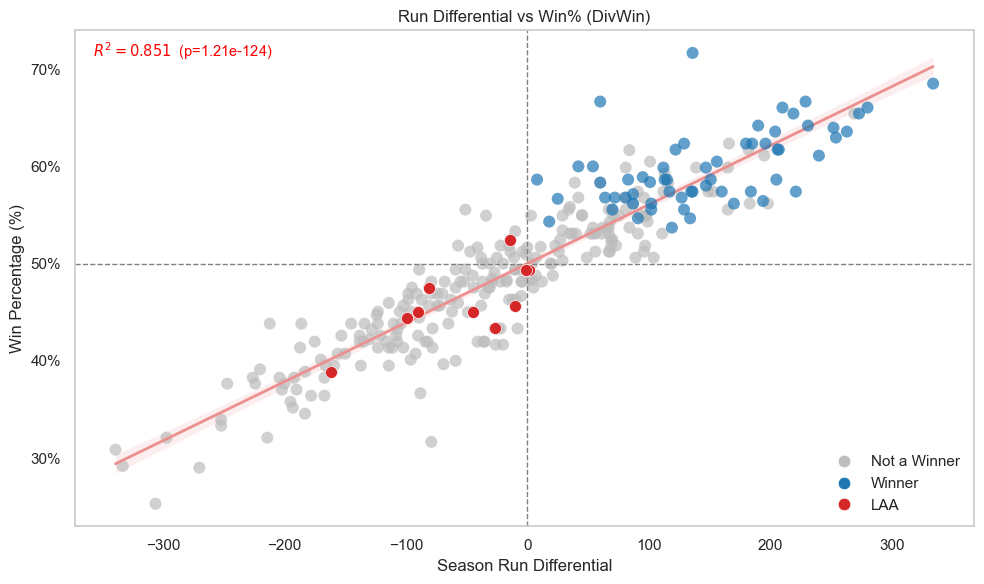

In [37]:
# Copy + remap labels
df = mlb_df.copy()
labeler = {0: "Not a Winner", 1: "Winner"}
df["DivWinLabel"] = df["DivWin"].map(labeler).fillna("Not a Winner")
df["LgWinLabel"]  = df["LgWin"].map(labeler).fillna("Not a Winner")
df["WSWinLabel"]  = df["WSWin"].map(labeler).fillna("Not a Winner")

laa = df[df["Team"] == "LAA"]  # overlay

COL_NOT = "#bdbdbd"   # gray
COL_WIN = "#1f77b4"   # blue
COL_LAA = "tab:red"   # red

fig, ax = plt.subplots(figsize=(10, 6))

def panel(ax, hue_col, title):
    # plot Not a Winner first (under)
    sns.scatterplot(
        data=df[df[hue_col] == "Not a Winner"],
        x="RunDiff", y="WinPct",
        color=COL_NOT, alpha=0.7, s=75, edgecolor="none",
        ax=ax, zorder=1
    )
    # plot Winner second (on top)
    sns.scatterplot(
        data=df[df[hue_col] == "Winner"],
        x="RunDiff", y="WinPct",
        color=COL_WIN, alpha=0.7, s=75, edgecolor="none",
        ax=ax, zorder=2
    )
    # overlay LAA last (top-most)
    sns.scatterplot(
        data=laa,
        x="RunDiff", y="WinPct",
        color=COL_LAA, s=75, edgecolor="white", linewidth=0.5,
        ax=ax, zorder=3
    )
   
    # reference lines
    ax.axhline(0.50, color="gray", ls="--", lw=1)
    ax.axvline(0,     color="gray", ls="--", lw=1)

    ax.set_title(title)
    ax.set_xlabel("Season Run Differential")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # 0–1 → %
    # don't touch grid settings (no new grid)

# Pearson r and p-value
r, p = pearsonr(df["RunDiff"], df["WinPct"])
ax.text(0.02, 0.98, f"$R^2={r**2:.3f}$  (p={p:.3g})",
        transform=ax.transAxes, ha="left", va="top", fontsize=10.5, color="red")

# regression line on the SAME axes
sns.regplot(data=df, x="RunDiff", y="WinPct",
            scatter=False, ci=95, line_kws={"color": "#eb8f8f", "lw": 2}, ax=ax)

# DivWin
panel(ax, "DivWinLabel", "Run Differential vs Win% (DivWin)")
ax.set_ylabel("Win Percentage (%)")
ax.grid(False)

# Legend (custom, consistent across panels)
legend_handles = [
    Line2D([], [], marker='o', color='none', markerfacecolor=COL_NOT,  markeredgecolor="white", 
           markeredgewidth=0.5, markersize=9, label="Not a Winner"
          ),
    Line2D([], [], marker='o', color='none', markerfacecolor=COL_WIN,  markeredgecolor="white", 
           markeredgewidth=0.5, markersize=9, label="Winner"
          ),
    Line2D([], [], marker='o', color='none', markerfacecolor=COL_LAA,  markeredgecolor="white", 
           markeredgewidth=0.5, markersize=9, label="LAA")
]
ax.legend(handles=legend_handles, frameon=False, title="", loc="best")

plt.tight_layout()
plt.savefig("LAA_RD_Div.png", dpi=300)
plt.show()

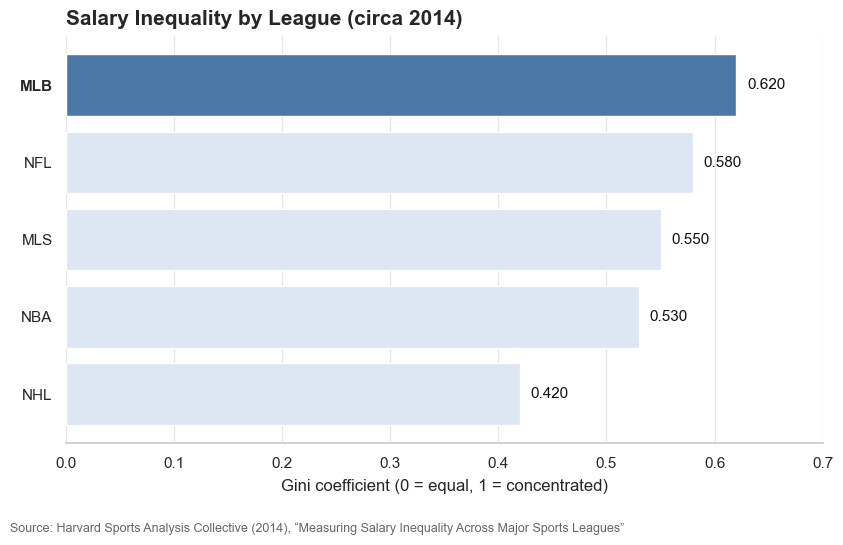

In [38]:
# --- Data from HSAC (2014) ---
data = {
    "MLB": 0.62,
    "NFL": 0.58,
    "MLS": 0.55,
    "NBA": 0.53,
    "NHL": 0.42,
}
df = pd.DataFrame(list(data.items()), columns=["League", "Gini"]).sort_values("Gini")

# --- Styling ---
HIGHLIGHT = "MLB"
ACCENT = "#4C78A8"    # MLB bar color
LIGHT  = "#DDE6F3"    # others (lighter)
GRID   = "#e6e6e6"

colors = [ACCENT if lg == HIGHLIGHT else LIGHT for lg in df["League"]]

fig, ax = plt.subplots(figsize=(8.5, 5.2))
bars = ax.barh(df["League"], df["Gini"], color=colors)

# value labels (decimal, not %)
for b, v in zip(bars, df["Gini"]):
    ax.text(v + 0.01, b.get_y() + b.get_height()/2, f"{v:.3f}",
            va="center", ha="left", fontsize=11, color="#111")

# axes & look
maxv = float(df["Gini"].max())
ax.set_xlim(0, maxv + 0.08)
ax.set_xlabel("Gini coefficient (0 = equal, 1 = concentrated)", labelpad=6)
ax.set_ylabel("")
ax.grid(True, axis="x", color=GRID, linewidth=1)
ax.grid(False, axis="y")
for sp in ["top","right","left"]:
    ax.spines[sp].set_visible(False)

# bold the MLB tick label
for tick in ax.get_yticklabels():
    if tick.get_text() == HIGHLIGHT:
        tick.set_fontweight("bold")

ax.set_title("Salary Inequality by League (circa 2014)", loc="left", pad=8,
             fontsize=15, fontweight="bold")

# credit
fig.text(
    0.01, -0.02,
    "Source: Harvard Sports Analysis Collective (2014), “Measuring Salary Inequality Across Major Sports Leagues”",
    ha="left", va="top", fontsize=9, color="#666"
)

plt.tight_layout()
plt.savefig("2014_MLB_COMP.png", dpi=150)
plt.show()

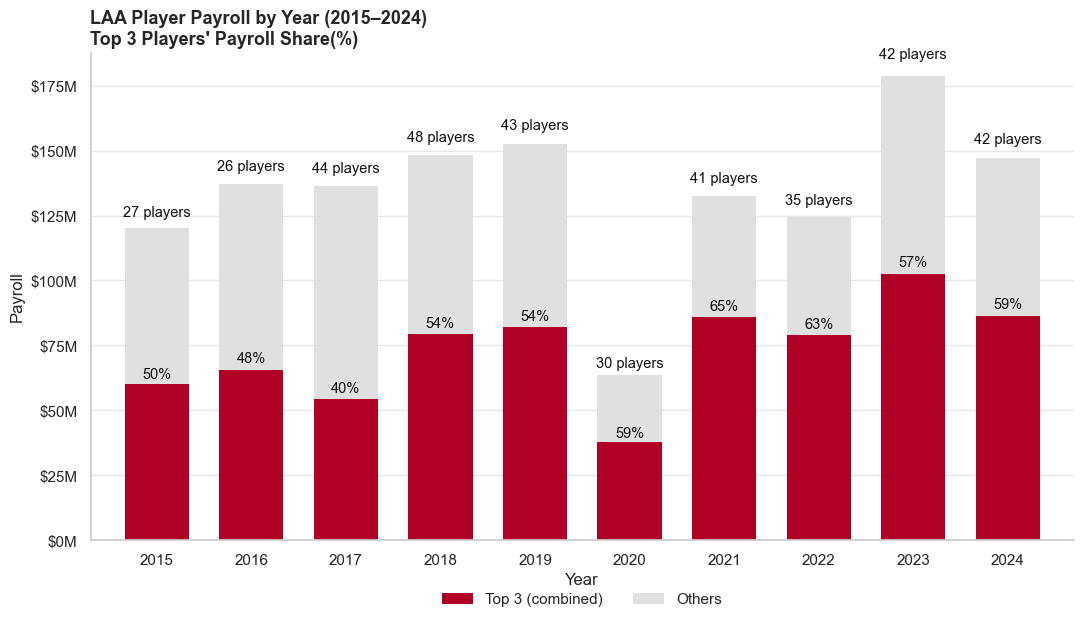

In [25]:
#  Clean salaries (expects Year, Team, Player, Salary) 
try:
    base_sal = salaries.copy()
except NameError:
    base_sal = sal.copy()

sal = base_sal.rename(columns={"Name": "Player"}) if "Name" in base_sal.columns else base_sal.copy()
needed = ["Year", "Team", "Player", "Salary"]
missing = [c for c in needed if c not in sal.columns]
if missing:
    raise ValueError(f"Missing needed columns: {missing}")

def to_number(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    return pd.to_numeric(re.sub(r"[^0-9.\-]", "", str(x)), errors="coerce")

sal["Salary"] = sal["Salary"].apply(to_number)
sal = sal.dropna(subset=["Salary"])

#  Filter to Angels + years 
team, yr_min, yr_max = "LAA", 2015, 2024
df = sal[(sal["Team"] == team) & (sal["Year"].between(yr_min, yr_max))].copy()
if df["Year"].dtype.kind not in "iu":
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

years = sorted(df["Year"].unique())
x = np.arange(len(years))

# Totals & counts per year
tot_salary = df.groupby("Year")["Salary"].sum().reindex(years, fill_value=0.0).astype(float).values
n_players  = df.groupby("Year")["Player"].nunique().reindex(years, fill_value=0).astype(int).values

# Top-3 combined vs Others 
top3_sum = []
others_sum = []
for y in years:
    yr = df[df["Year"] == y].sort_values("Salary", ascending=False)
    t3 = yr["Salary"].head(3).sum()
    top3_sum.append(float(t3))
    others_sum.append(float(yr["Salary"].iloc[3:].sum() if len(yr) > 3 else 0.0))

top3_sum   = np.array(top3_sum)
others_sum = np.array(others_sum)
top3_pct   = np.where(tot_salary > 0, (top3_sum / tot_salary) * 100.0, np.nan)

#   Plot (red top-3, gray others)
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(11, 6.4))

RED_MAIN = "#B10026"   # Top-3 block (bottom)
GRAY     = "#E0E0E0"   # Others (top)
bar_width = 0.68       # ↓ for more gap between years; ↑ for tighter

# Currency formatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _:
    f"${v/1e9:.1f}B" if abs(v) >= 1e9 else f"${v/1e6:.0f}M"))

# Stacks: Top-3 (bottom) then Others (top)
b0 = np.zeros_like(top3_sum)
bars_top3 = ax.bar(x, top3_sum, bar_width, color=RED_MAIN, edgecolor="none", bottom=b0, label="Top 3")
b1 = b0 + top3_sum
bars_oth  = ax.bar(x, others_sum, bar_width, color=GRAY,     edgecolor="none", bottom=b1, label="Others")

# ---------- 5) Annotations ----------
# (A) Top-3 % just above red stack (on gray)
for i in range(len(years)):
    if np.isfinite(top3_pct[i]) and top3_sum[i] > 0:
        y = b1[i] + max(others_sum[i]*0.02, tot_salary[i]*0.01)
        ax.text(x[i], y, f"{top3_pct[i]:.0f}%", ha="center", va="bottom",
                fontsize=10.5, color="#111")

# (B) Total players at the very top
for i in range(len(years)):
    y = (b1[i] + others_sum[i]) + (tot_salary[i] * 0.03)
    ax.text(x[i], y, f"{n_players[i]} players", ha="center", va="bottom",
            fontsize=10.5, color="#111")

# ---------- 6) Axes & legend ----------
ax.set_xticks(x)
ax.set_xticklabels([str(y) for y in years])
ax.set_xlim(x.min()-0.7, x.max()+0.7)
ax.set_title("LAA Player Payroll by Year (2015–2024)\nTop 3 Players' Payroll Share(%)",
             loc="left", fontsize=13, fontweight="bold")
ax.set_xlabel("Year"); ax.set_ylabel("Payroll")
ax.grid(True, axis="y", color="#e6e6e6"); ax.grid(False, axis="x")
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)

legend_items = [
    Patch(facecolor=RED_MAIN, edgecolor="none", label="Top 3 (combined)"),
    Patch(facecolor=GRAY,     edgecolor="none", label="Others"),
]
ax.legend(handles=legend_items, ncol=2, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
plt.savefig("LAA_Payroll_Blank.png", dpi=300)
plt.show()

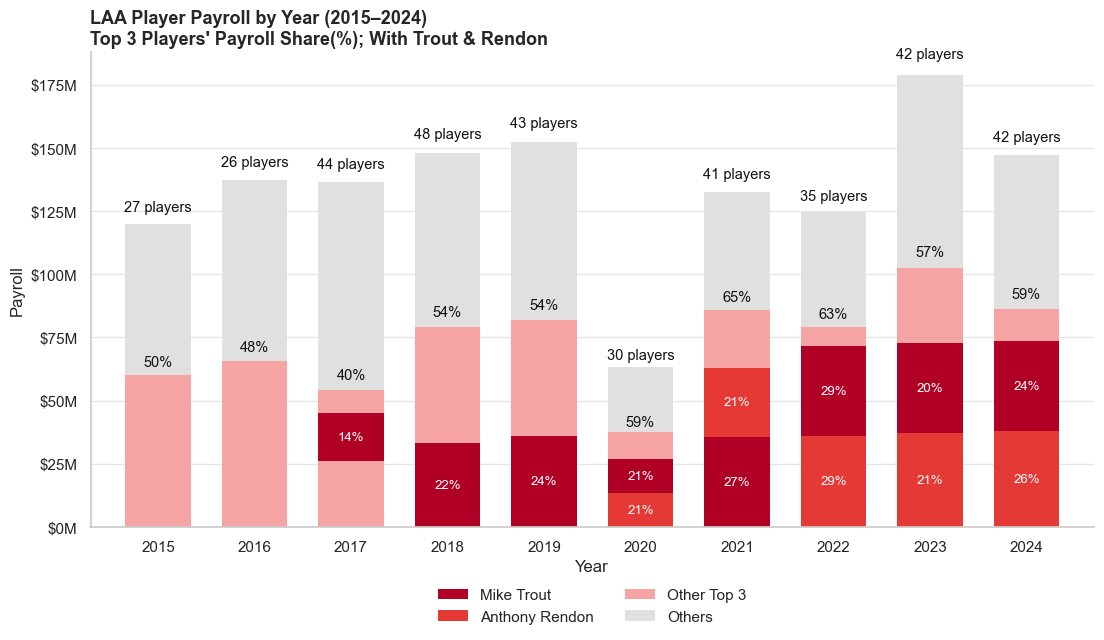

In [24]:
# 1) Clean salaries
# Expect: Year, Team, Player, Salary
try:
    base_sal = salaries.copy()
except NameError:
    base_sal = sal.copy()

sal = base_sal.rename(columns={"Name": "Player"}) if "Name" in base_sal.columns else base_sal.copy()
needed = ["Year", "Team", "Player", "Salary"]
missing = [c for c in needed if c not in sal.columns]
if missing:
    raise ValueError(f"Missing needed columns: {missing}")

def to_number(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    return pd.to_numeric(re.sub(r"[^0-9.\-]", "", str(x)), errors="coerce")

sal["Salary"] = sal["Salary"].apply(to_number)
sal = sal.dropna(subset=["Salary"])

# 2) Filter to Angels + years
team, yr_min, yr_max = "LAA", 2015, 2024
df = sal[(sal["Team"] == team) & (sal["Year"].between(yr_min, yr_max))].copy()
if df["Year"].dtype.kind not in "iu":
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

years = sorted(df["Year"].unique())
x = np.arange(len(years))

# Totals per year
tot_salary = df.groupby("Year")["Salary"].sum().reindex(years, fill_value=0.0).astype(float).values
n_players  = df.groupby("Year")["Player"].nunique().reindex(years, fill_value=0).astype(int).values

# 3) Build Top-3 stacks + Others 
COLOR_TROUT    = "#B10026"  # deep red
COLOR_RENDON   = "#E53935"  # bright red
COLOR_TOP3_OTH = "#F5A3A3"  # pastel red
COLOR_OTHERS   = "#E0E0E0"  # light gray

TOP1, TOP2, TOP3, OTHERS = [], [], [], []
col1, col2, col3 = [], [], []

# stores per-player % label for Trout/Rendon (else empty) by rank/year
label1, label2, label3 = [], [], []

for y in years:
    yr = df[df["Year"] == y].sort_values("Salary", ascending=False)
    t3 = yr.head(3).reset_index(drop=True)
    others_sum = yr["Salary"].iloc[3:].sum() if len(yr) > 3 else 0.0
    total_y = tot_salary[list(years).index(y)]

    # helpers
    def prc_txt(player, sal):
        return f"{(sal/total_y*100):.0f}%" if total_y > 0 else ""

    # rank 1
    if len(t3) >= 1:
        p1, s1 = t3.loc[0, "Player"], float(t3.loc[0, "Salary"])
        TOP1.append(s1)
        if str(p1).lower() == "mike trout":
            col1.append(COLOR_TROUT);  label1.append(prc_txt(p1, s1))
        elif str(p1).lower() == "anthony rendon":
            col1.append(COLOR_RENDON); label1.append(prc_txt(p1, s1))
        else:
            col1.append(COLOR_TOP3_OTH); label1.append("")
    else:
        TOP1.append(0.0); col1.append(COLOR_TOP3_OTH); label1.append("")

    # rank 2
    if len(t3) >= 2:
        p2, s2 = t3.loc[1, "Player"], float(t3.loc[1, "Salary"])
        TOP2.append(s2)
        if str(p2).lower() == "mike trout":
            col2.append(COLOR_TROUT);  label2.append(prc_txt(p2, s2))
        elif str(p2).lower() == "anthony rendon":
            col2.append(COLOR_RENDON); label2.append(prc_txt(p2, s2))
        else:
            col2.append(COLOR_TOP3_OTH); label2.append("")
    else:
        TOP2.append(0.0); col2.append(COLOR_TOP3_OTH); label2.append("")

    # rank 3
    if len(t3) >= 3:
        p3, s3 = t3.loc[2, "Player"], float(t3.loc[2, "Salary"])
        TOP3.append(s3)
        if str(p3).lower() == "mike trout":
            col3.append(COLOR_TROUT);  label3.append(prc_txt(p3, s3))
        elif str(p3).lower() == "anthony rendon":
            col3.append(COLOR_RENDON); label3.append(prc_txt(p3, s3))
        else:
            col3.append(COLOR_TOP3_OTH); label3.append("")
    else:
        TOP3.append(0.0); col3.append(COLOR_TOP3_OTH); label3.append("")

    OTHERS.append(float(others_sum))

TOP1 = np.array(TOP1); TOP2 = np.array(TOP2); TOP3 = np.array(TOP3); OTHERS = np.array(OTHERS)

# Top-3 share per year (for the label above the red stack)
top3_sum = TOP1 + TOP2 + TOP3
top3_pct = np.where(tot_salary > 0, (top3_sum / tot_salary) * 100.0, np.nan)

# 4) Plot 
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(11.2, 6.6))
bar_width = 0.68  # reduce to create gaps between years

# y-axis formatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _:
    f"${v/1e9:.1f}B" if abs(v) >= 1e9 else f"${v/1e6:.0f}M"))

# stack: Top1 (bottom) -> Top2 -> Top3 -> Others (top gray)
b0 = np.zeros_like(TOP1)
bars1 = ax.bar(x, TOP1, bar_width, color=col1, edgecolor="none", bottom=b0)
b1 = b0 + TOP1
bars2 = ax.bar(x, TOP2, bar_width, color=col2, edgecolor="none", bottom=b1)
b2 = b1 + TOP2
bars3 = ax.bar(x, TOP3, bar_width, color=col3, edgecolor="none", bottom=b2)
b3 = b2 + TOP3
barsO = ax.bar(x, OTHERS, bar_width, color=COLOR_OTHERS, edgecolor="none", bottom=b3)

#  5) Labels
def contrast_color(hex_color):
    h = hex_color.lstrip("#")
    r, g, b = int(h[0:2],16)/255, int(h[2:4],16)/255, int(h[4:6],16)/255
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "white" if lum < 0.55 else "#111"

# (A) Inside segments: Trout/Rendon show their own % of total payroll
for i in range(len(years)):
    # rank1 label
    if label1[i]:
        ymid = b0[i] + TOP1[i]/2
        ax.text(x[i], ymid, label1[i], ha="center", va="center",
                fontsize=9.5, color=contrast_color(col1[i]))
    # rank2
    if label2[i]:
        ymid = b1[i] + TOP2[i]/2
        ax.text(x[i], ymid, label2[i], ha="center", va="center",
                fontsize=9.5, color=contrast_color(col2[i]))
    # rank3
    if label3[i]:
        ymid = b2[i] + TOP3[i]/2
        ax.text(x[i], ymid, label3[i], ha="center", va="center",
                fontsize=9.5, color=contrast_color(col3[i]))

# (B) On gray just above red stack: Top-3 % (e.g., "67%")
for i in range(len(years)):
    if np.isfinite(top3_pct[i]) and top3_sum[i] > 0:
        y = b3[i] + (OTHERS[i] * 0.02 + tot_salary[i] * 0.01)  # small nudge
        ax.text(x[i], y, f"{top3_pct[i]:.0f}%", ha="center", va="bottom",
                fontsize=10.5, color="#111")

# (C) On very top: total players (e.g., "28 players")
for i in range(len(years)):
    y = (b3[i] + OTHERS[i]) + (tot_salary[i] * 0.03)  # higher nudge
    ax.text(x[i], y, f"{n_players[i]} players", ha="center", va="bottom",
            fontsize=10.5, color="#111")

#  6) Axes & styling 
ax.set_xticks(x)
ax.set_xticklabels([str(y) for y in years])
ax.set_xlim(x.min()-0.7, x.max()+0.7)
ax.set_title("LAA Player Payroll by Year (2015–2024)\nTop 3 Players' Payroll Share(%); With Trout & Rendon",
             loc="left", fontsize=13, fontweight="bold")
ax.set_xlabel("Year"); ax.set_ylabel("Payroll")
ax.grid(True, axis="y", color="#e6e6e6"); ax.grid(False, axis="x")
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)

# Legend
legend_items = [
    Patch(facecolor=COLOR_TROUT,    edgecolor="none", label="Mike Trout"),
    Patch(facecolor=COLOR_RENDON,   edgecolor="none", label="Anthony Rendon"),
    Patch(facecolor=COLOR_TOP3_OTH, edgecolor="none", label="Other Top 3"),
    Patch(facecolor=COLOR_OTHERS,   edgecolor="none", label="Others"),
]
ax.legend(handles=legend_items, ncol=2, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.10))

plt.tight_layout()
plt.savefig("LAA_Salary.png", dpi=300)
plt.show()

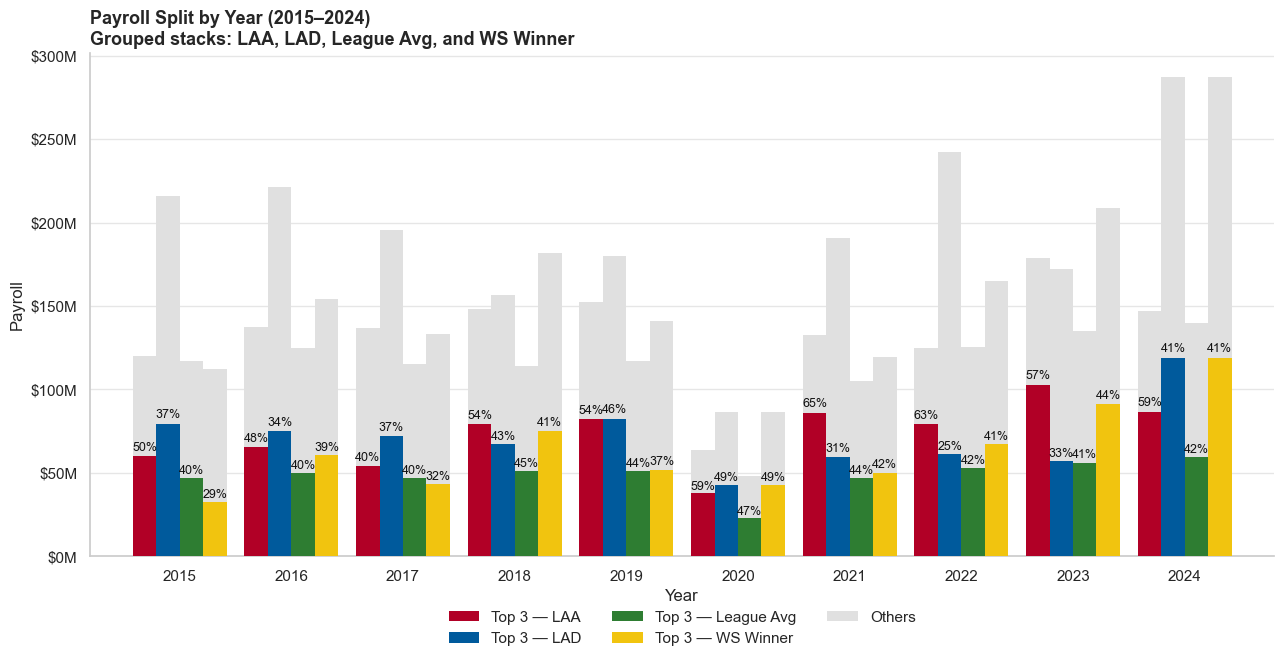

In [26]:
#  Inputs 
yr_min, yr_max = 2015, 2024
TEAM_LAA = "LAA"
TEAM_LAD = "LAD"

#  Salaries table: Year, Team, Player, Salary 
try:
    base_sal = salaries.copy()
except NameError:
    base_sal = sal.copy()  # if you've already prepared a cleaned `sal`

sal = base_sal.rename(columns={"Name": "Player"}) if "Name" in base_sal.columns else base_sal.copy()
need = ["Year","Team","Player","Salary"]
miss = [c for c in need if c not in sal.columns]
if miss:
    raise ValueError(f"Missing columns in salaries: {miss}")

def to_number(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int,float)): return float(x)
    return pd.to_numeric(re.sub(r"[^0-9.\-]", "", str(x)), errors="coerce")

sal["Salary"] = sal["Salary"].apply(to_number)
sal = sal.dropna(subset=["Salary"])

# Ensure Year numeric and filter range
if sal["Year"].dtype.kind not in "iu":
    sal["Year"] = pd.to_numeric(sal["Year"], errors="coerce")
sal = sal.dropna(subset=["Year"]).copy()
sal["Year"] = sal["Year"].astype(int)
sal = sal[sal["Year"].between(yr_min, yr_max)]

years = np.arange(yr_min, yr_max+1)
year_str = [str(y) for y in years]

#  Helpers 
def top3_vs_others_by_team(sal_df, team):
    """Return arrays (top3, others) aligned to `years` for a single team across years."""
    sub = sal_df[sal_df["Team"] == team]
    g = sub.groupby("Year")["Salary"]
    top3  = g.apply(lambda s: s.nlargest(3).sum()).reindex(years, fill_value=0.0).to_numpy(float)
    total = g.sum().reindex(years, fill_value=0.0).to_numpy(float)
    others = np.maximum(total - top3, 0.0)
    return top3, others, total

def league_avg_top3_vs_others(sal_df):
    """Average per team per year: compute Top3 & Others for each team-year, then mean across teams."""
    g = sal_df.groupby(["Team","Year"])["Salary"]
    top3_ty  = g.apply(lambda s: s.nlargest(3).sum()).rename("Top3").reset_index()
    total_ty = g.sum().rename("Total").reset_index()
    merged = top3_ty.merge(total_ty, on=["Team","Year"], how="inner")
    merged["Others"] = merged["Total"] - merged["Top3"]
    yr = (
        merged.groupby("Year")[["Top3","Others","Total"]]
              .mean()
              .reindex(years, fill_value=0.0)
              .reset_index()
    )
    return yr["Top3"].to_numpy(float), yr["Others"].to_numpy(float), yr["Total"].to_numpy(float)

def ws_winner_top3_vs_others(sal_df, mlb_df):
    """For each year, pick WS winner team from mlb_df, compute that team-year's Top3/Others from salaries."""
    df = mlb_df.copy()
    if df["Year"].dtype.kind not in "iu":
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df = df.dropna(subset=["Year"]).copy()
    df["Year"] = df["Year"].astype(int)
    winners = df[(df["Year"].between(yr_min, yr_max)) & (df["WSWin"] == 1)].sort_values("Year")
    winners = winners.drop_duplicates(subset=["Year"], keep="first")
    year_to_team = dict(zip(winners["Year"], winners["Team"]))

    top3 = np.zeros(len(years), dtype=float)
    others = np.zeros(len(years), dtype=float)
    total = np.zeros(len(years), dtype=float)
    for i, y in enumerate(years):
        t = year_to_team.get(y, None)
        if t is None:  # no winner row found (shouldn't happen), leave zeros
            continue
        sub = sal_df[(sal_df["Team"] == t) & (sal_df["Year"] == y)]
        if len(sub) == 0:
            continue
        sals = sub["Salary"]
        top3[i]  = sals.nlargest(3).sum()
        total[i] = sals.sum()
        others[i]= max(total[i] - top3[i], 0.0)
    return top3, others, total

#  Compute series 
laa_top3, laa_oth, laa_tot = top3_vs_others_by_team(sal, TEAM_LAA)
lad_top3, lad_oth, lad_tot = top3_vs_others_by_team(sal, TEAM_LAD)
avg_top3, avg_oth, avg_tot = league_avg_top3_vs_others(sal)
win_top3, win_oth, win_tot = ws_winner_top3_vs_others(sal, mlb_df)

#  Plot: grouped + stacked 
fig, ax = plt.subplots(figsize=(13, 6.8))

# Colors
RED     = "#B10026"  # LAA
BLUE    = "#005A9C"  # LAD
GREEN   = "#2E7D32"  # League avg
YELLOW  = "#F1C40F"  # WS winner
GRAY    = "#E0E0E0"

# Group geometry
group_width = 0.84
w = group_width / 4.0
offs = np.array([-1.5, -0.5, 0.5, 1.5]) * w

def money_fmt(v,_):
    return f"${v/1e9:.1f}B" if abs(v) >= 1e9 else f"${v/1e6:.0f}M"
ax.yaxis.set_major_formatter(FuncFormatter(money_fmt))

# helper to draw one grouped, stacked series
def draw_series(xbase, top3, others, color, label_top3, label_others=None):
    b0 = np.zeros_like(top3)
    ax.bar(xbase, top3,  w, color=color, edgecolor="none", bottom=b0, label=label_top3, zorder=3)
    ax.bar(xbase, others,w, color=GRAY,  edgecolor="none", bottom=(b0+top3),
           label=label_others if label_others else None, zorder=2)

x = np.arange(len(years))
# LAA (red)
draw_series(x + offs[0], laa_top3, laa_oth, RED,    "Top 3 — LAA", "Others")
# LAD (blue)
draw_series(x + offs[1], lad_top3, lad_oth, BLUE,   "Top 3 — LAD")
# League avg (green)
draw_series(x + offs[2], avg_top3, avg_oth, GREEN,  "Top 3 — League Avg")
# WS winner (yellow)
draw_series(x + offs[3], win_top3, win_oth, YELLOW, "Top 3 — WS Winner")

# Axes & grid
ax.set_xticks(x)
ax.set_xticklabels(year_str)
ax.set_xlim(-0.8, len(years)-0.2)
ax.set_title("Payroll Split by Year (2015–2024)\nGrouped stacks: LAA, LAD, League Avg, and WS Winner", loc="left",
             fontsize=13, fontweight="bold")
ax.set_xlabel("Year"); ax.set_ylabel("Payroll")
ax.grid(True, axis="y", color="#e6e6e6"); ax.grid(False, axis="x")
for spine in ("top","right"): ax.spines[spine].set_visible(False)

# Legend (unique handles)
handles = [
    Patch(facecolor=RED,    edgecolor="none", label="Top 3 — LAA"),
    Patch(facecolor=BLUE,   edgecolor="none", label="Top 3 — LAD"),
    Patch(facecolor=GREEN,  edgecolor="none", label="Top 3 — League Avg"),
    Patch(facecolor=YELLOW, edgecolor="none", label="Top 3 — WS Winner"),
    Patch(facecolor=GRAY,   edgecolor="none", label="Others"),
]
ax.legend(handles=handles, ncol=3, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.08))

def add_pct_labels(xbase, top3, total):
    pct = np.where(total>0, top3/total, np.nan)
    for xi, t3, p in zip(xbase, top3, pct):
        if t3>0 and np.isfinite(p):
            ax.text(xi, t3*1.02, f"{p*100:.0f}%", ha="center", va="bottom", fontsize=9, color="#111")
add_pct_labels(x+offs[0], laa_top3, laa_tot)
add_pct_labels(x+offs[1], lad_top3, lad_tot)
add_pct_labels(x+offs[2], avg_top3, avg_tot)
add_pct_labels(x+offs[3], win_top3, win_tot)
plt.draw()

plt.tight_layout()
plt.savefig("all_Salary.png", dpi=300)
plt.show()